In [18]:
import numpy as np
import networkx as nx
import kmapper as km
import sklearn
import warnings
import matplotlib.pyplot as plt
import signal
import time
import random
import pandas as pd
import matplotlib.pyplot as plt
from networkx.algorithms.similarity import graph_edit_distance


warnings.filterwarnings("ignore")

In [2]:
def select_k(spectrum, minimum_energy = 0.9):
    running_total = 0.0 
    
    total = sum(spectrum)
    if total == 0.0:
        return len(spectrum)
    for i in range(len(spectrum)):
        running_total += spectrum[i]
        if running_total / total >= minimum_energy:
            return i + 1
    return len(spectrum)

In [3]:
def calculate_similarity(graph1,graph2):
    laplacian1 = nx.spectrum.laplacian_spectrum(graph1)
    laplacian2 = nx.spectrum.laplacian_spectrum(graph2)
    
    k1 = select_k(laplacian1)
    k2 = select_k(laplacian2)
    k = min(k1, k2) #k are different between the two graphs, then use the smaller one.
    similarity = sum((laplacian1[:k] - laplacian2[:k])**2) #sum of the squared differences between the largest k eigenvalues
    return similarity

In [4]:
def extract_graph_features(graph):
    pr = nx.pagerank(graph,0.9)
    dc = nx.degree_centrality(graph)
    cc = nx.closeness_centrality(graph)
    bx = nx.betweenness_centrality(graph)
    c = nx.clustering(graph)
    
    #create list for each features
    pr_list =  [i for i in pr.values()]
    dc_list =  [i for i in dc.values()]
    cc_list =  [i for i in cc.values()]
    bx_list =  [i for i in bx.values()]
    c_list =  [i for i in c.values()]
    d_list = [val for (node, val) in graph.degree()]
    data = np.column_stack((pr_list,dc_list,cc_list,bx_list,c_list,d_list))
    return data

In [5]:
def TDA_transformation(data):
    Xfilt = data
    mapper = km.KeplerMapper()
    scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
    Xfilt = scaler.fit_transform(Xfilt)
    lens = mapper.fit_transform(Xfilt, projection=sklearn.manifold.TSNE())
    cls = 5  # We use cls= 5

    graph = mapper.map(lens,Xfilt,clusterer=sklearn.cluster.KMeans(n_clusters=cls,random_state=1618033),
        cover=km.Cover(n_cubes=2, perc_overlap=0.3))
    return km.to_nx(graph)

In [6]:
def add_node_to_graph(graph,p):
    new_node = graph.number_of_nodes() + 1
    graph.add_node(new_node)
    existing_nodes = list(graph.nodes())[:-1]  # Exclude the new node
    for existing_node in existing_nodes:
        if random.random() < p:  
            graph.add_edge(new_node, existing_node)
    return graph

In [7]:
def remove_least_degree_node(graph):
    degrees = graph.degree()
    min_degree_node = min(degrees, key=lambda x: x[1])[0]
    # Remove the node with the minimum degree
    graph.remove_node(min_degree_node)
    return graph

In [8]:
def random_add_new_edge(graph):
    node_num = graph.number_of_nodes()
    node1 = random.randint(1,node_num)
    node2 = random.randint(1,node_num)
    while graph.has_edge(node1,node2) or node1 == node2 :
        node1 = random.randint(1,node_num)
        node2 = random.randint(1,node_num)
    graph.add_edge(node1,node2)
    return graph

In [9]:
def random_remove_edge(graph):
    random_edge = random.choice(list(graph.edges()))
    # Remove the randomly selected edge
    graph.remove_edge(*random_edge)
    return graph

In [10]:
def graph_generator(original_graph, node, edge,p):
    new_graph = original_graph.copy()
    if node < 0:
        for i in range(abs(node)):
            new_graph = remove_least_degree_node(new_graph)
    elif node > 0:
        for i in range(abs(node)):
            new_graph = add_node_to_graph(new_graph,p)
    
    if edge < 0:
        for i in range(abs(edge)):
            new_graph = random_remove_edge(new_graph)
    elif edge >0:
        for i in range(abs(edge)):
            new_graph = random_add_new_edge(new_graph)
    return new_graph

In [11]:
def calc_original_average_similarity_for_hop(graph, hop,p):
    counter = 0
    sum = 0
    for i in range(-hop,hop + 1):
        for j in range(-hop,hop + 1):
            if (i == -hop or i == hop or j == -hop or j == hop):
                neighbour = graph_generator(graph,j,i,p)
                score = calculate_similarity(graph, neighbour)
                sum += score
                counter += 1
    return sum/counter

In [12]:
def calc_TDA_average_similarity_for_hop(graph, hop,p):
    counter = 0
    sum = 0
    for i in range(-hop,hop + 1):
        for j in range(-hop,hop + 1):
            if (i == -hop or i == hop or j == -hop or j == hop):
                neighbour = graph_generator(graph,j,i,p)
                TDA_graph = TDA_transformation(extract_graph_features(graph))
                TDA_neighbour = TDA_transformation(extract_graph_features(neighbour))
                score = calculate_similarity(TDA_graph, TDA_neighbour)
                sum += score
                counter += 1
    return sum/counter

In [13]:
def calc_both_average_similarity_for_hop(graph, hop,p):
    counter = 0
    sum_original = 0
    sum_TDA = 0
    for i in range(-hop,hop + 1):
        for j in range(-hop,hop + 1):
            if (i == -hop or i == hop or j == -hop or j == hop):
                neighbour = graph_generator(graph,j,i,p)
                TDA_graph = TDA_transformation(extract_graph_features(graph))
                TDA_neighbour = TDA_transformation(extract_graph_features(neighbour))
                
                score_TDA = calculate_similarity(TDA_graph, TDA_neighbour)
                score_original = calculate_similarity(graph, neighbour)
                
                sum_TDA += score_TDA
                sum_original += score_original
                counter += 1
    return {"TDA": sum_TDA/counter,"original": sum_original/counter}

In [14]:
def calc_hop_v1():
    threshold = 50
    n = random.randint(30,50)
    reach_max = False
    
    p = round(random.uniform(60, 100))/100
#     n = 30
#     p = 0.6
    reference_graph = nx.erdos_renyi_graph(n,p)
    
    TDA_average = 0
    original_average = 0
    
    TDA_hop = 0
    original_hop = 0
    while (TDA_average <= threshold or original_average <= threshold) and TDA_hop < 15:
        if(TDA_average <= threshold and original_average <= threshold):
            TDA_hop += 1
            original_hop += 1
            result = calc_both_average_similarity_for_hop(reference_graph,TDA_hop ,p)
            TDA_average = result['TDA']
            original_average = result['original']
            print(TDA_average,original_average)
        elif(TDA_average <= threshold):
            TDA_hop += 1
            TDA_average = calc_TDA_average_similarity_for_hop(reference_graph,TDA_hop,p)
            print(TDA_average)
        elif(original_average <= threshold):
            original_hop += 1
            original_average = calc_original_average_similarity_for_hop(reference_graph,original_hop,p)
            

    if(reach_max):
        return {"Threshold": threshold, "n":n,"p":p,"last_TDA_average": TDA_average, "last_original_average": original_average,
               "TDA_hop": TDA_hop + "+","orginal_hop":original_hop}
    else:
        return {"Threshold": threshold, "n":n,"p":p,"last_TDA_average": TDA_average, "last_original_average": original_average,
               "TDA_hop": TDA_hop,"orginal_hop":original_hop}
#     return {"TDA_hop":TDA_hop,"orginnal":original_hop}

In [15]:
def calc_average_for_hop(hop,ref_graph,n,p,delta_n,delta_p):
    sum_original = 0
    sum_TDA = 0
    counter = 0
    for i in range(-hop,hop + 1):
        for j in range(-hop,hop + 1):
            if (i == -hop or i == hop or j == -hop or j == hop):
                neighbour = nx.erdos_renyi_graph(i*delta_n + n,j*delta_p + p)
                
                TDA_graph = TDA_transformation(extract_graph_features(ref_graph))
                TDA_neighbour = TDA_transformation(extract_graph_features(neighbour))
                
                score_TDA = calculate_similarity(TDA_graph, TDA_neighbour)
                score_original = calculate_similarity(ref_graph, neighbour)
                
                sum_TDA += score_TDA
                sum_original += score_original
                counter += 1
    return {"hop:" : hop,"TDA": sum_TDA/counter,"original": sum_original/counter}
                

In [16]:
G = nx.erdos_renyi_graph(30,0.3)

result = calc_average_for_hop(hop = 1,ref_graph = G,n = 30,p = 0.3,delta_n = 2,delta_p = 0.05)
result

{'hop:': 1, 'TDA': 12.434904464471185, 'original': 59.53202784587371}

In [17]:
result = calc_average_for_hop(hop = 2,ref_graph = G,n = 30,p = 0.3,delta_n = 2,delta_p = 0.05)
result

{'TDA': 12.272861381934323, 'original': 228.77719987633557}

In [18]:
def conduct_test_for_on_graph(graph,n,p,delta_n,delta_p,n_hop):
    result = [dict() for x in range(n_hop)]
    for i in range(n_hop):
        result[i] = calc_average_for_hop(hop =i+1,ref_graph = graph,n = n,p = p,delta_n = delta_n,delta_p = delta_p)
    return {"n" : n,"p" : p,"Result" : result}
    

In [19]:
result = conduct_test_for_on_graph(G,30,0.3,2,0.05,4)
result

{'n': 30,
 'p': 0.3,
 'Result': [{'hop:': 1,
   'TDA': 14.518635709368334,
   'original': 106.7837020939187},
  {'hop:': 2, 'TDA': 11.482247659528452, 'original': 207.91993591758887},
  {'hop:': 3, 'TDA': 10.726883074164393, 'original': 406.5660067412607},
  {'hop:': 4, 'TDA': 16.944016554031197, 'original': 713.561204281232}]}

In [43]:
row = []
row.append(result['n'])
row.append(result['p'])
column = []
column.append('n')
column.append('p')
hop_result = result['Result']
for i in range(len(hop_result)):
    original_text = "Original_"
    TDA_text = "TDA_"
    original_text = original_text + str(i+1)
    TDA_text = TDA_text + str(i+1)
    column.append(original_text)
    column.append(TDA_text)
    row.append(hop_result[i]['original'])
    row.append(hop_result[i]['TDA'])
print(len(row))
print(len(column))

row_list = []
row_list.append(row)

df = pd.DataFrame(row_list,columns=column)
df




10
10


,n,p,Original_1,TDA_1,Original_2,TDA_2,Original_3,TDA_3,Original_4,TDA_4
0,30,0.3,106.783702,14.518636,207.919936,11.482248,406.566007,10.726883,713.561204,16.944017


In [55]:
def conduct_test_on_sample(sample_numbers,n_hop):
    column = []
    row_list = []
    column.append('n')
    column.append('p')
    
    for i in range(n_hop):
        original_text = "Original_"
        TDA_text = "TDA_"
        original_text = original_text + str(i+1)
        TDA_text = TDA_text + str(i+1)
        column.append(original_text)
        column.append(TDA_text)
        
    for i in range(sample_numbers):
        row =[]
        n = random.randint(30,50)       
        p = round(random.uniform(5, 40))/100
        row.append(n)
        row.append(p)
        reference_graph = nx.erdos_renyi_graph(n,p)
        result = conduct_test_for_on_graph(reference_graph,n,p,2,0.05,n_hop)['Result']

        for j in range(n_hop):
            row.append(result[j]['original'])
            row.append(result[j]['TDA'])
        row_list.append(row)
       
    df = pd.DataFrame(row_list,columns= column)
    return df
        

In [56]:
df = conduct_test_on_sample(30,4)
print(df)

     n     p  Original_1      TDA_1  Original_2      TDA_2   Original_3  \
0   31  0.37   74.286462  16.085173  263.154775  12.242410   464.941151   
1   44  0.17  160.143938   7.968708  565.878234  10.644066  1300.006881   
2   32  0.06  114.927615  23.315522  166.972280  26.164313   338.279794   
3   36  0.31  142.619044  12.639442  295.691601   8.107587   658.914849   
4   35  0.07   96.522634  12.518330  275.650436  25.168690   407.894503   
5   33  0.09   65.910757  10.424345  210.655706  24.404173   384.678809   
6   38  0.18  100.414891  11.541901  323.368808   9.020934   804.746160   
7   30  0.07   89.940984   9.181912  211.923676  32.834623   278.930238   
8   45  0.22  203.421281  10.162724  603.453343  13.582069  1320.390137   
9   39  0.13  119.876294   7.532852  408.591010  17.352380   728.873913   
10  35  0.22   91.675332  14.124347  338.288343  10.069981   615.025089   
11  31  0.23   56.974133   5.392246  191.108612  10.371278   420.858661   
12  50  0.30  181.684254 

In [70]:
df.to_csv("30_sample_graphs.csv")

In [65]:
df

,n,p,Original_1,TDA_1,Original_2,TDA_2,Original_3,TDA_3,Original_4,TDA_4
0,31,0.37,74.286462,16.085173,263.154775,12.242410,464.941151,12.756891,829.814128,12.195814
1,44,0.17,160.143938,7.968708,565.878234,10.644066,1300.006881,11.006991,1794.846339,22.274176
2,32,0.06,114.927615,23.315522,166.972280,26.164313,338.279794,26.468011,557.814720,28.210587
3,36,0.31,142.619044,12.639442,295.691601,8.107587,658.914849,9.326129,1137.451140,16.414136
4,35,0.07,96.522634,12.518330,275.650436,25.168690,407.894503,26.063843,562.512621,28.254421
5,33,0.09,65.910757,10.424345,210.655706,24.404173,384.678809,28.554666,581.580408,28.002020
6,38,0.18,100.414891,11.541901,323.368808,9.020934,804.746160,8.745408,1270.562836,22.098904
7,30,0.07,89.940984,9.181912,211.923676,32.834623,278.930238,28.763998,428.331038,29.120398
8,45,0.22,203.421281,10.162724,603.453343,13.582069,1320.390137,9.657559,2281.212420,15.458362
9,39,0.13,119.876294,7.532852,408.591010,17.352380,728.873913,22.302556,1120.340531,24.426270


In [2]:

df_read = pd.read_csv('30_sample_graphs.csv',index_col=False)
df_read.drop(columns=['Unnamed: 0'])

,n,p,Original_1,TDA_1,Original_2,TDA_2,Original_3,TDA_3,Original_4,TDA_4
0,31,0.37,74.286462,16.085173,263.154775,12.242410,464.941151,12.756891,829.814128,12.195814
1,44,0.17,160.143938,7.968708,565.878234,10.644066,1300.006881,11.006991,1794.846339,22.274176
2,32,0.06,114.927615,23.315522,166.972280,26.164313,338.279794,26.468011,557.814720,28.210587
3,36,0.31,142.619044,12.639442,295.691601,8.107587,658.914849,9.326129,1137.451140,16.414136
4,35,0.07,96.522634,12.518330,275.650436,25.168690,407.894503,26.063843,562.512621,28.254421
5,33,0.09,65.910757,10.424345,210.655706,24.404173,384.678809,28.554666,581.580408,28.002020
6,38,0.18,100.414891,11.541901,323.368808,9.020934,804.746160,8.745408,1270.562836,22.098904
7,30,0.07,89.940984,9.181912,211.923676,32.834623,278.930238,28.763998,428.331038,29.120398
8,45,0.22,203.421281,10.162724,603.453343,13.582069,1320.390137,9.657559,2281.212420,15.458362
9,39,0.13,119.876294,7.532852,408.591010,17.352380,728.873913,22.302556,1120.340531,24.426270


In [5]:
original_1 = df_read['Original_1'].tolist()
original_1

[74.2864620185085,
 160.14393768008327,
 114.92761463939716,
 142.61904443058637,
 96.52263440465688,
 65.91075693361746,
 100.41489114492984,
 89.94098372025684,
 203.42128090645912,
 119.87629441357493,
 91.6753316797358,
 56.97413333911824,
 181.6842541657284,
 218.39156069049935,
 169.8323060109287,
 133.93649495133167,
 82.81938628772349,
 140.76082834725932,
 209.10901507633736,
 132.86259966138613,
 191.7674967839976,
 178.94744588137956,
 148.74597293016325,
 77.13710673420566,
 75.50704156477549,
 123.5875820712572,
 79.76413578123733,
 251.6725748663565,
 176.72987060000358,
 153.05009622252643]

In [9]:
original_average =[]
TDA_avaerage = []
for i in range(4):
    original_text = "Original_" + str(i+1)
    TDA_text = "TDA_" + str(i+1)
    original_list = df_read[original_text].tolist()
    tda_list = df_read[TDA_text].tolist()
    original_sum = 0
    tda_sum = 0
    for j in range(len(original_list)):
        original_sum = original_sum + original_list[j]
        tda_sum = tda_sum + tda_list[j]
    original_average.append(round(original_sum/len(original_list),2))
    TDA_avaerage.append(round(tda_sum/len(tda_list),2))
    
  
        

In [10]:
original_average

[134.77, 401.15, 798.82, 1280.2]

In [11]:
TDA_avaerage

[12.26, 15.77, 17.58, 20.42]

<AxesSubplot:>

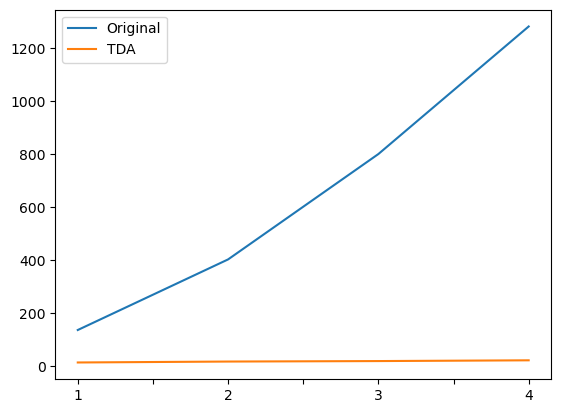

In [30]:
average_df = pd.DataFrame({'Original' : original_average,'TDA': TDA_avaerage},index=['1','2','3','4'])
average_df.plot.line()

In [16]:
orignal_df = pd.DataFrame({'Original' : original_average},index=[1,2,3,4])

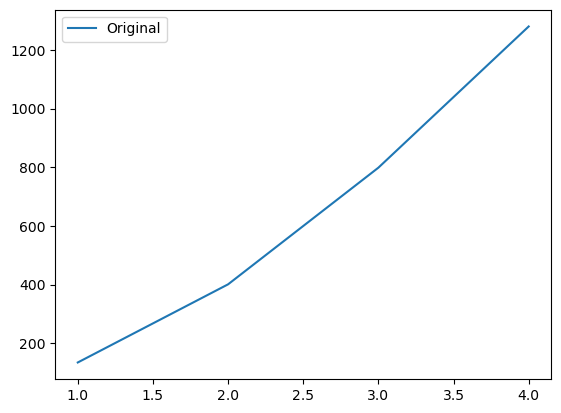

In [19]:
lines = orignal_df.plot.line()

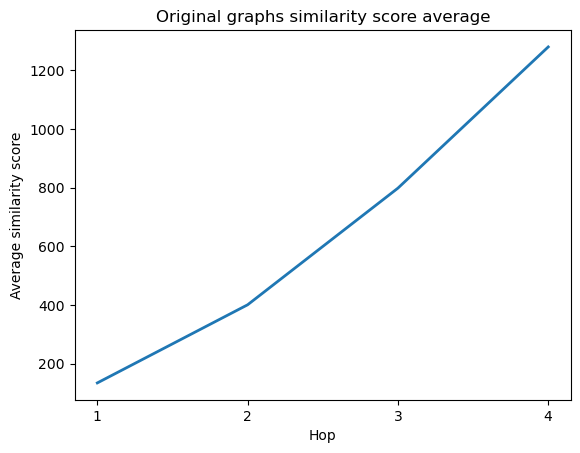

In [26]:
hop = ['1','2','3','4']
plt.plot(hop, original_average,linewidth=2, markersize=12)
plt.title('Original graphs similarity score average')
plt.xlabel('Hop')
plt.ylabel('Average similarity score')
plt.savefig("original.jpg")
plt.show()

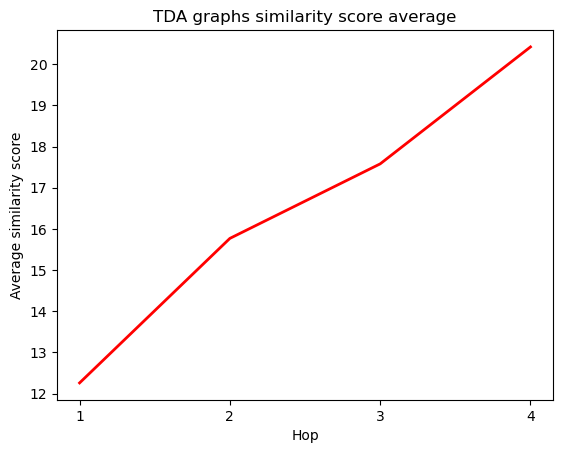

In [27]:
plt.plot(hop, TDA_avaerage,linewidth=2, markersize=12,color='red')
plt.title('TDA graphs similarity score average')
plt.xlabel('Hop')
plt.ylabel('Average similarity score')
plt.savefig("TDA.jpg")
plt.show()